<a id="t1."></a>
# 1. Import data and python packages

In [162]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import pandas as pd

In [163]:
# Define paths
train_directory = Path("../Beef1/Meat/train")
test_directory = Path("../Beef1/Meat/test")
valid_directory = Path("../Beef1/Meat/valid")

In [164]:
# Set the desired sample size
sample_size = 1033

# Set the desired width and height for resizing images
width = 224
height = 224

In [165]:
files = ['Fresh', 'Melted']

def load_images(directory, files, sample_size):
    data = {}
    for f in files:
        data[f] = []

    for col in files:
        dir_path = directory / col
        image_files = [file for file in os.listdir(dir_path) if file.endswith('.jpg')]
        
        # Use all images if fewer than sample_size
        if len(image_files) < sample_size:
            selected_files = image_files
        else:
            selected_files = np.random.choice(image_files, sample_size, replace=False)
        
        for file in selected_files:
            data[col].append(os.path.join(dir_path, file))

    image_data = []
    image_target = []

    for title in files:
        for file in data[title]:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, (width, height))
            image_data.append(img_resized)
            image_target.append(title)
    
    return np.array(image_data), np.array(image_target)

# Load and preprocess training data
image_train_data, image_train_target = load_images(train_directory, files, sample_size)
image_test_data, image_test_target = load_images(test_directory, files, sample_size)
image_valid_data, image_valid_target = load_images(valid_directory, files, sample_size)

In [166]:
# Verify loaded data
print(f"Training data shape: {image_train_data.shape}")
print(f"Training labels shape: {image_train_target.shape}")
print(f"Test data shape: {image_test_data.shape}")
print(f"Test labels shape: {image_test_target.shape}")
print(f"Validation data shape: {image_valid_data.shape}")
print(f"Validation labels shape: {image_valid_target.shape}")

Training data shape: (2066, 224, 224, 3)
Training labels shape: (2066,)
Test data shape: (464, 224, 224, 3)
Test labels shape: (464,)
Validation data shape: (464, 224, 224, 3)
Validation labels shape: (464,)


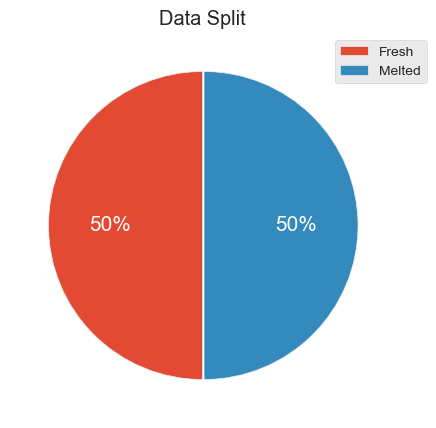

In [167]:
# Plot the data distribution
sizes = [len(image_train_target[image_train_target == 'Fresh']), len(image_train_target[image_train_target == 'Melted'])]

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color':"w", "fontsize":15}, startangle=90, explode=(0, .01))
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

<a id="t2."></a>
# 2. Data visualization

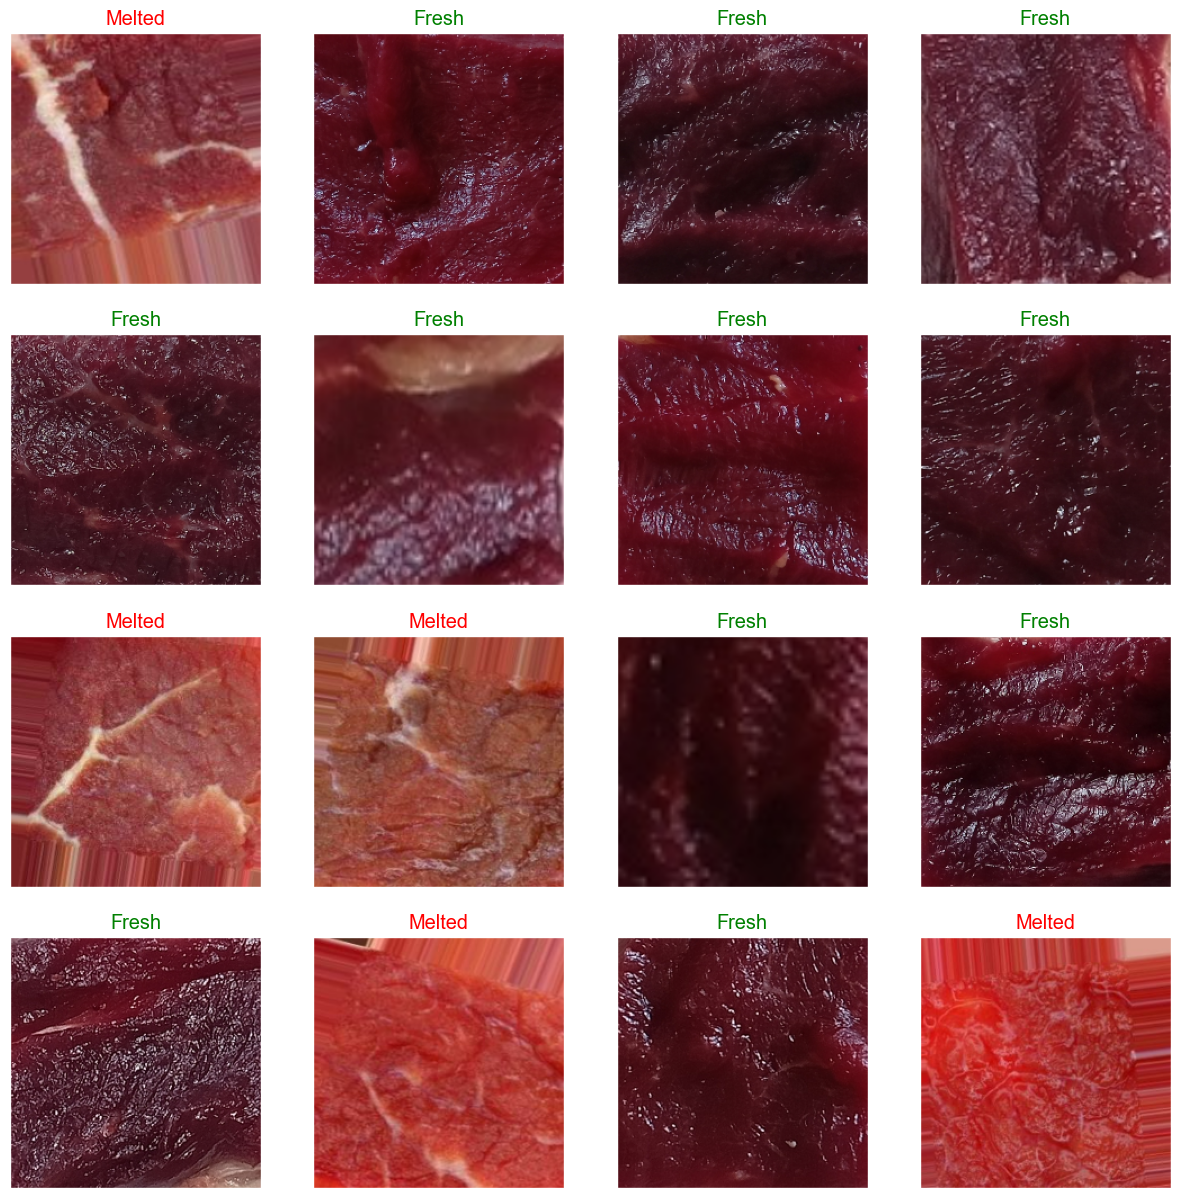

In [168]:
# Define size_train to be the length of image_train_data
size_train = len(image_train_data)

plt.figure(figsize=(15, 15))
for i in range(1, 17):
    fig = np.random.randint(size_train)
    plt.subplot(4, 4, i)
    plt.imshow(image_train_data[fig])
    if image_train_target[fig] == 'Fresh':
        c = 'green'
    else:
        c = 'red'
    plt.title(image_train_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

<a id="t3."></a>
# 3. Classification (CNN)

In [169]:
from sklearn.preprocessing import LabelEncoder

In [170]:
labels = LabelEncoder()
labels.fit(image_train_target)

LabelEncoder()

In [171]:
# Normalize the images
X_train = image_train_data / 255.0
X_test = image_test_data / 255.0
X_valid = image_valid_data / 255.0

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(image_train_target)
y_test = label_encoder.transform(image_test_target)
y_valid = label_encoder.transform(image_valid_target)

In [172]:


# train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.15, random_state=123)

# #Bagi data menjadi set pelatihan (70%) dan set sementara (30%)
# train_images, temp_images, train_labels, temp_labels = train_test_split(X, y, test_size=0.30, random_state=123)
# 
# #Bagi set sementara menjadi set validasi (15%) dan set pengujian (15%)
# validation_images, test_images, validation_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.50, random_state=123)

# Memeriksa ukuran set
print(f"Train set size: {y_train.shape[0]}")
print(f"Validation set size: {y_valid.shape[0]}")
print(f"Test set size: {y_test.shape[0]}")

Train set size: 2066
Validation set size: 464
Test set size: 464


In [173]:
from tensorflow.keras.utils import to_categorical
    
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

In [174]:
# train_images, train_labels = X , y
# test_images , test_labels = tX, ty

In [175]:
# Membuat model Sequential
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [176]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [177]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_20 (Ba  (None, 222, 222, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_21 (Ba  (None, 111, 111, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 32)      4640      
                                                      

In [178]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Call_Back = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model-2', monitor='val_loss', save_best_only=True)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.99):
            print("\nReached or Exceed 99.0% accuracy so cancelling training!")
            self.model.stop_training = True
            
callback = myCallback()

In [179]:
# history = model.fit(train_images, 
#                     train_labels,
#                     epochs=10, 
#                     batch_size=32, 
#                     validation_data=(validation_images, validation_labels), callbacks=[early_stopping])

# from sklearn.model_selection import KFold
# 
# kfold = KFold(n_splits=5, shuffle=True, random_state=123)
# for train_index, val_index in kfold.split(X):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
    
# history = model.fit(X_train, y_train, 
#                     validation_data=(X_val, y_val), 
#                     epochs=10, batch_size=32, 
#                     callbacks=[Call_Back, ModelCheckpoint, callback])
    

In [180]:
# from sklearn.preprocessing import LabelEncoder

# # Convert train_labels and test_labels to integers using LabelEncoder
# label_encoder = LabelEncoder()
# train_labels_encoded = label_encoder.fit_transform(train_labels)
# test_labels_encoded = label_encoder.transform(test_labels)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    verbose=1,
    callbacks=[callback,callback]
)


Epoch 1/20
65/65 [==============================] - 21s 296ms/step - loss: 0.0847 - accuracy: 0.9811 - val_loss: 20.8352 - val_accuracy: 0.5000
Epoch 2/20
65/65 [==============================] - 19s 291ms/step - loss: 0.2532 - accuracy: 0.9932 - val_loss: 0.3779 - val_accuracy: 0.9591
Epoch 3/20
65/65 [==============================] - 19s 287ms/step - loss: 0.1415 - accuracy: 0.9956 - val_loss: 12.3058 - val_accuracy: 0.6724
Epoch 4/20
65/65 [==============================] - 19s 291ms/step - loss: 0.1807 - accuracy: 0.9961 - val_loss: 2.7415 - val_accuracy: 0.8750
Epoch 5/20
65/65 [==============================] - 19s 289ms/step - loss: 0.1708 - accuracy: 0.9952 - val_loss: 0.1545 - val_accuracy: 0.9871
Epoch 6/20
65/65 [==============================] - 19s 289ms/step - loss: 6.6012e-04 - accuracy: 1.0000 - val_loss: 0.1611 - val_accuracy: 0.9849
Epoch 7/20
65/65 [==============================] - 19s 291ms/step - loss: 0.0019 - accuracy: 0.9990 - val_loss: 0.1623 - val_accuracy: 

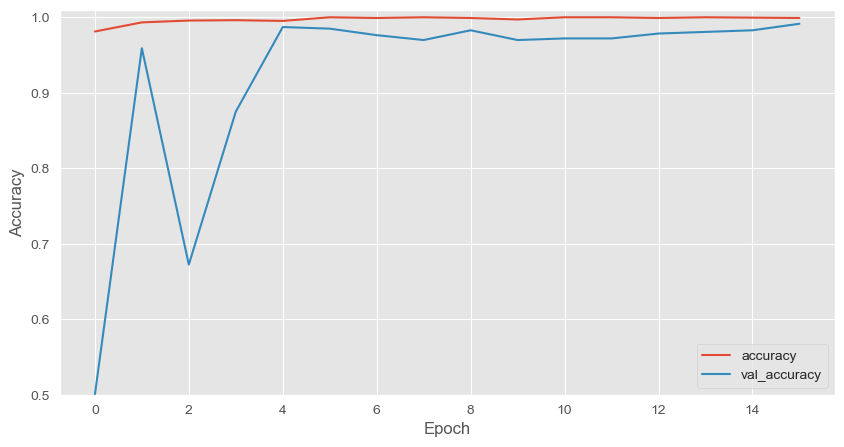

In [181]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

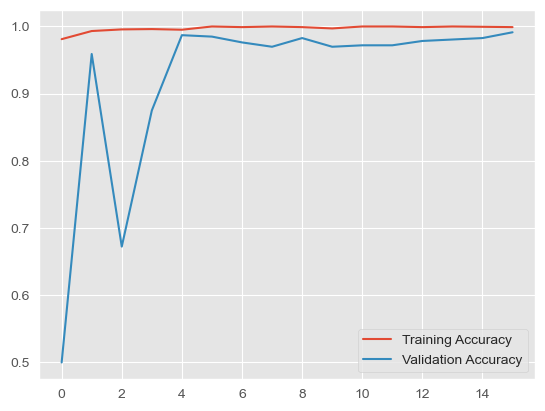

In [182]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [183]:
result=model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 85ms/step - loss: 3.0905 - accuracy: 0.9763


In [184]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 3.0904927253723145
accuracy : 0.9762930870056152


<a id="t4."></a>
# 4. Prediction

In [185]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

15/15 [==============================] - 1s 84ms/step


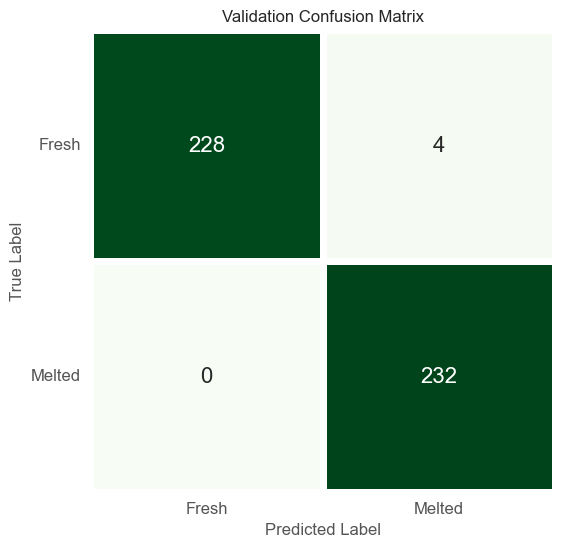

In [186]:
# Prediksi pada data validasi
y_val_pred = model.predict(X_valid)

# Definisi fungsi untuk mengkonversi prediksi ke kelas
def toClass(pred):
    return np.argmax(pred, axis=1)

# Membuat confusion matrix untuk data validasi
cm_val = confusion_matrix(y_valid, toClass(y_val_pred))

df_val = pd.DataFrame(columns=["Fresh", "Melted"], index=["Fresh", "Melted"], data=cm_val)

f_val, ax_val = plt.subplots(figsize=(6, 6))
sns.heatmap(df_val, annot=True, cmap="Greens", fmt='.0f', ax=ax_val, linewidths=5, cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size=12)
plt.yticks(size=12, rotation=0)
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix", size=12)
plt.show()

15/15 [==============================] - 1s 84ms/step


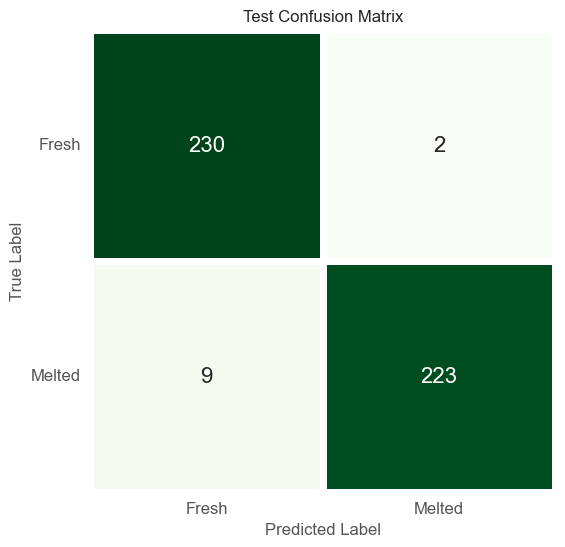

In [187]:
y_pred = model.predict(X_test)

def toClass(pred):
    return np.argmax(pred, axis=1)

cm = confusion_matrix(y_test, toClass(y_pred))

df1 = pd.DataFrame(columns=["Fresh","Melted"], index= ["Fresh","Melted"], data= cm)

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Test Confusion Matrix", size = 12)
plt.show()


In [188]:
from sklearn.metrics import classification_report

# Prediksi kelas untuk data uji
y_pred_class = toClass(y_pred)

# Buat classification report
report = classification_report(y_test, y_pred_class, target_names=files)

# Tampilkan classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       Fresh       0.96      0.99      0.98       232
      Melted       0.99      0.96      0.98       232

    accuracy                           0.98       464
   macro avg       0.98      0.98      0.98       464
weighted avg       0.98      0.98      0.98       464


In [189]:
def prediction(image):
    global width, height, model
    
    img = cv2.resize(image, (width, height))
    img = img / 255.0
    pred = model.predict(np.array([img])).argmax()
    
    return files[pred]

1/1 [==============================] - 0s 29ms/step


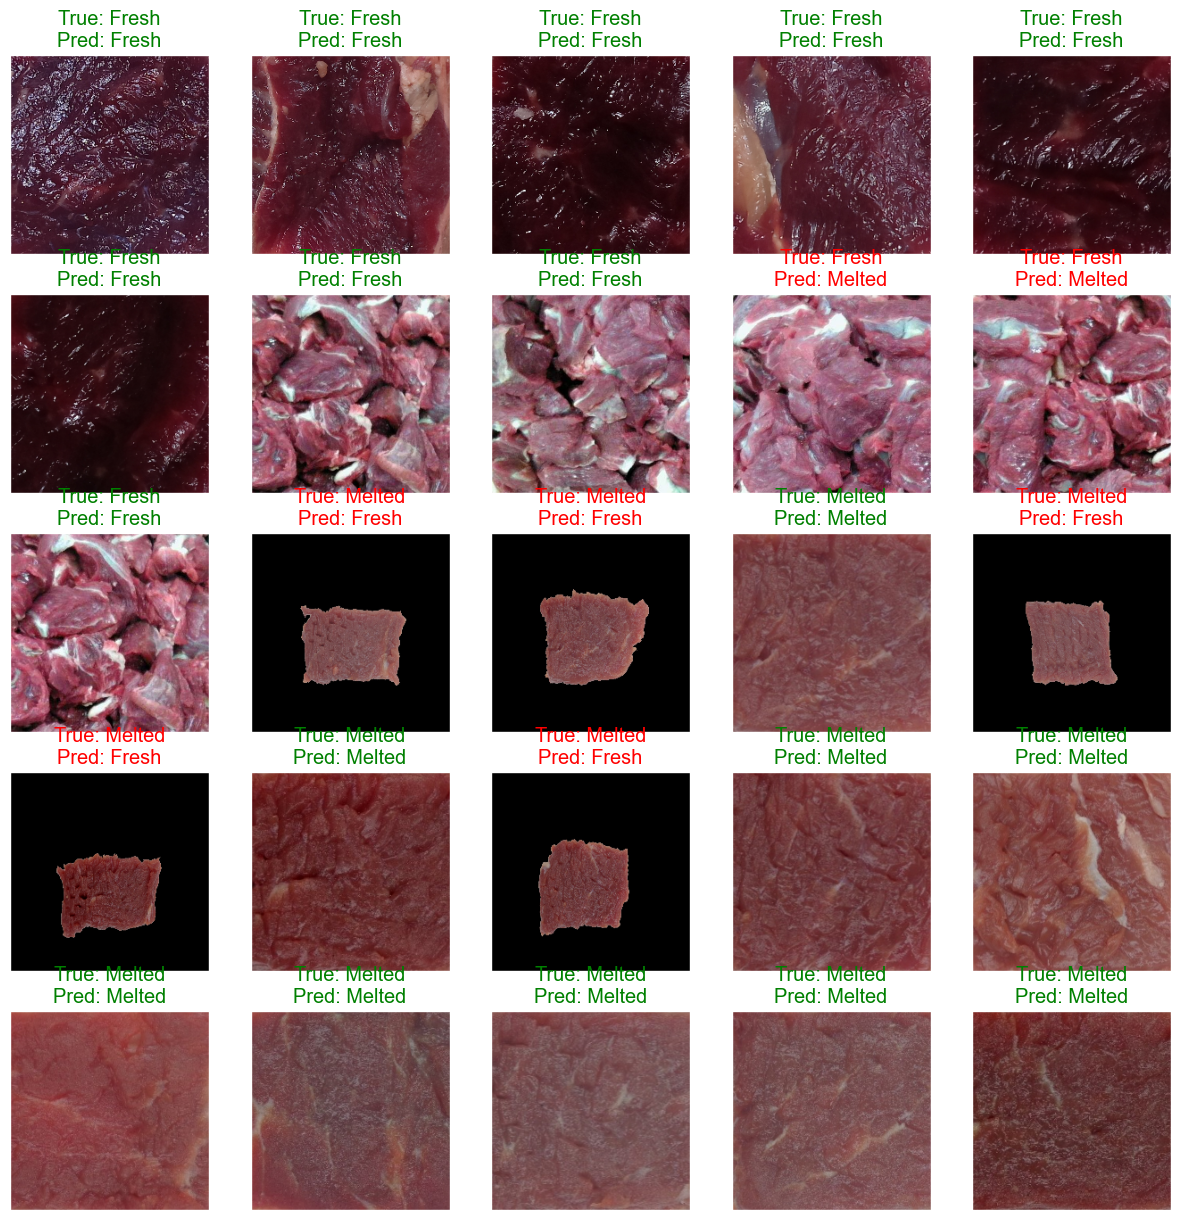

In [190]:

start_index = 220  # Indeks awal untuk menampilkan gambar
num_images = 25  # Jumlah gambar yang ingin ditampilkan
size_test = len(image_test_data)

plt.figure(figsize=(15,15))
for i in range(1, num_images + 1):
    fig = start_index + i
    plt.subplot(5, 5, i)
    plt.imshow(image_test_data[fig])
    actual_label = image_test_target[fig]
    predicted_label = prediction(image_test_data[fig])
    if actual_label == predicted_label:
        c = 'green'
    else:
        c = 'red'
    plt.title(f"True: {actual_label}\nPred: {predicted_label}", color=c)
    plt.xticks([]), plt.yticks([])
plt.show()